In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup as Bs
import gensim.downloader as api
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

nltk.download('wordnet')
nltk.download('omw-1.4')
wn = WordNetLemmatizer()

tokenizer = ToktokTokenizer()

word2vec = api.load('word2vec-google-news-300')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chare\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def process_text(text: str):
    """
    This function will process the text data by:
    1. Removing HTML tags and converting to lowercase.
    2. Tokenizing the text.
    3. Removing special characters.
    4. Removing stopwords.
    5. Lemmatizing the text.

    :param text: str
    :return: processed_text: str
    """
    text = Bs(text, 'html.parser').get_text().lower()

    tokens = tokenizer.tokenize(text)

    tokens = [re.sub(r'[^a-zA-z0-9]', '', token) for token in tokens if token.isalnum()]

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [wn.lemmatize(word) for word in tokens]

    return tokens

In [4]:
def feature_extraction_word2vec(text: str):
    """
    This function extracts features from the text data using Word2Vec embeddings.
    :param text: str
    :return: feature_vector: np.array
    """
    # Split the preprocessed text into words

    tokens = process_text(text)
    feature_vector = np.array([word2vec[word] for word in tokens if word in word2vec]).mean(axis=0).reshape(1, -1)
    return feature_vector

In [16]:
df = pd.read_csv('../data/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
y = df['sentiment'].to_numpy().reshape(-1, 1)
X = np.zeros((df.shape[0], 1, 300))
for i, review in enumerate(df['review']):
    new_data = feature_extraction_word2vec(review)
    X[i] = new_data
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


C:\Users\chare\AppData\Local\Temp\ipykernel_7888\3966708587.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = Bs(text, 'html.parser').get_text().lower()


(45000, 1, 300) (5000, 1, 300) (45000, 1) (5000, 1)


In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [62]:
# Define the model
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(1, 300)))  # Adjust input_shape
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [63]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 1/100
654/654 [==============================] - 10s 10ms/step - loss: 0.4666 - binary_accuracy: 0.7800 - accuracy: 0.7800 - val_loss: 0.3840 - val_binary_accuracy: 0.8396 - val_accuracy: 0.8396
Epoch 2/100
654/654 [==============================] - 6s 9ms/step - loss: 0.4312 - binary_accuracy: 0.8060 - accuracy: 0.8060 - val_loss: 0.3815 - val_binary_accuracy: 0.8351 - val_accuracy: 0.8351
Epoch 3/100
654/654 [==============================] - 6s 9ms/step - loss: 0.4213 - binary_accuracy: 0.8110 - accuracy: 0.8110 - val_loss: 0.3834 - val_binary_accuracy: 0.8258 - val_accuracy: 0.8258
Epoch 4/100
654/654 [==============================] - 6s 9ms/step - loss: 0.4154 - binary_accuracy: 0.8138 - accuracy: 0.8138 - val_loss: 0.3763 - val_binary_accuracy: 0.8340 - val_accuracy: 0.8340
Epoch 5/100
654/654 [==============================] - 6s 9ms/step - loss: 0.4100 - binary_accuracy: 0.8173 - accuracy: 0.8173 - val_loss: 0.3774 - val_binary_accuracy: 0.8364 - val_accuracy: 0.8364
Epo

In [68]:
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

157/157 [==============================] - 0s 2ms/step - loss: 0.3423 - binary_accuracy: 0.8486 - accuracy: 0.8486


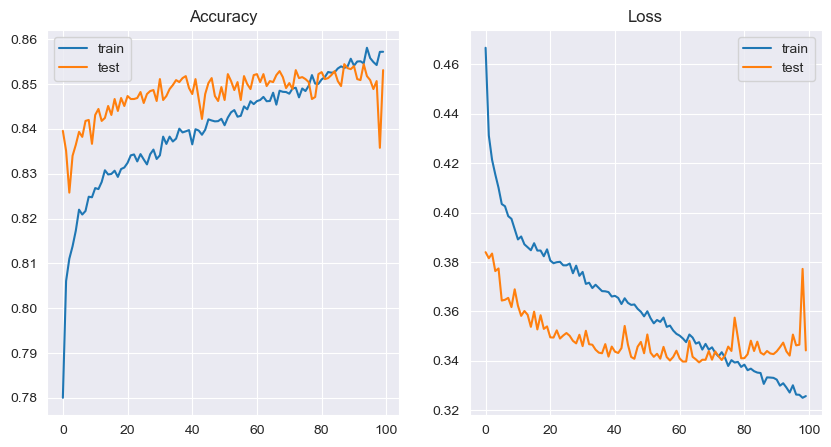

In [64]:
# Save the model
model.save('models/word2vec_model.h5')

In [69]:
# plot model
tf.keras.utils.plot_model(model, to_file='models/word2vec_model.png', show_shapes=True, show_layer_names=True)

In [81]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score)

1/1 [==============================] - 0s 17ms/step


array([[ True],
       [False],
       [False]])

In [82]:
def predict_review(review: str):
    """
    This function predicts the sentiment of the review.
    :param review: str
    :return: prediction: str
    """
    feature_vector = feature_extraction_word2vec(review)
    print(type(feature_vector))
    prediction = model.predict(feature_vector)
    # if prediction > 0.5:
    #     return 'positive'
    # else:
    #     return 'negative'

In [ ]:
predict_review('This movie is really good. I liked it a lot.')